In [125]:
#take boxes determined by marisol from kathleens biforcation data and calculate average environmental information for them
#want to calculate average SST, SSS, u^2+v^2, and var(u^2+v^2)
import xarray as xr
#import pandas as pd
#import matplotlib as mpl
#import openpyxl
#from mpl_toolkits.basemap import Basemap
#import matplotlib.pyplot as plt
import numpy as np
#from math import cos, radians
import datetime as dt

dir_cmc='F:/data/sst/cmc/CMC0.2deg/v2/'
dir_cmc_clim='F:/data/sst/cmc/CMC0.2deg/v2/climatology/'
dir_clim='F:/data/sat_data/oscar/L4/oscar_third_deg/climatology/'
dir_data = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/'
dir_figs = 'F:/data/eddy/figures/'

boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2']
boxes_lon_min = [-160,-130,-125,-130,-148]
boxes_lon_max = [-170,-140,-135,-140,-158]
boxes_lat_min = [41,46,35,52,52]
boxes_lat_max = [46,51,40,57,57]
boxes_lon_min_180 = boxes_lon_min[:]
boxes_lon_max_180 = boxes_lon_max[:]
for i in range(0,5):
    boxes_lon_min[i] += 360
    boxes_lon_max[i] += 360


In [18]:
filename_oscar_clim = dir_clim + 'oscar_v2009_1993_2016_climatology_12202118.nc'
filename_oscar_out = 'F:/data/eddy/bifurcation_ms/oscar_boxes_timeseries.nc'
#make oscar timeseries
#for ibox in range(0,2): #5):
inc=-1
for box in boxes_names:
    inc+=1 
    for lyr in range(2000,2018):
        filename = dir_data + 'oscar_vel' + str(lyr).zfill(4) + '.nc.gz'
        ds=xr.open_dataset(filename,drop_variables=['um','vm'])
        ds_subset = ds.sel(longitude=slice(boxes_lon_max[inc],boxes_lon_min[inc]),latitude=slice(boxes_lat_max[inc],boxes_lat_min[inc])) 
        ds_subset['tot_vel']=(ds_subset.u**2+ds_subset.v**2)**.5       
        ds_subset['tot_vel_var']=ds_subset.tot_vel**2      
        ds_subset['u_sq']=ds_subset.u**2       
        ds_subset['v_sq']=ds_subset.v**2      
        ds_mean = ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    
        if lyr==2000:
            ds_box = ds_mean
        else:
            ds_box = xr.concat([ds_box,ds_mean],dim='time')
        #print(box)
    if box=='NPC':
        ds_newbox = ds_box
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        #print(ds_newbox.box)
ds_newbox.to_netcdf(filename_oscar_out)

C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [107]:
filename_oscar_out = 'F:/data/eddy/bifurcation_ms/oscar_boxes_timeseries.nc'
ds_oscar = xr.open_dataset(filename_oscar_out)
ds_oscar.close()
filename_TS_out = 'F:/data/eddy/bifurcation_ms/cmc_sst_boxes_timeseries.nc'
ds_cmc = xr.open_dataset(filename_TS_out)
ds_cmc.close()

In [108]:
ds_cmc.analysed_sst

<xarray.DataArray 'analysed_sst' (box: 5, time: 204)>
array([[280.896  , 280.42236, 279.98483, ..., 286.63214, 282.3721 , 281.20325],
       [280.83206, 280.2752 , 280.11566, ..., 287.4697 , 284.65613, 282.26688],
       [286.5712 , 285.77274, 285.2329 , ..., 291.57358, 290.26672, 288.50558],
       [226.09615, 225.85991, 225.9254 , ..., 230.95132, 229.30843, 227.76654],
       [272.3556 , 272.04407, 272.13733, ..., 279.67575, 277.04572, 274.90247]],
      dtype=float32)
Dimensions without coordinates: box, time

In [118]:
min(ds_cmc.time[:])

<xarray.DataArray 'time' ()>
array(0, dtype=int64)

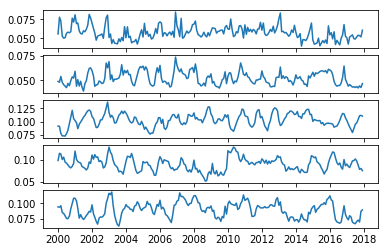

F:/data/eddy/figures/boxes_oscar.png


In [128]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
for i in range(0,5):
    plt.subplot(5, 1, i+1)
    plt.plot(ds_oscar.time[:],ds_oscar.tot_vel[i,:,0])
    #plt.plot(ds_cmc.time[:],ds_cmc.analysed_sst[i,:]-273.15,'r')
fig_fname=dir_figs+"boxes_oscar.png"
#fig_fname=dir_figs+"boxes_sst.png"
plt.savefig(fig_fname, transparent=False, format='png')
plt.show()
print(fig_fname)

In [99]:
#filename_oscar_clim = dir_clim + 'oscar_v2009_1993_2016_climatology_12202118.nc'
filename_TS_out = 'F:/data/eddy/bifurcation_ms/cmc_sst_boxes_timeseries.nc'
#make cmc timeseries
#for ibox in range(0,2): #5):
inc=-1
for box in boxes_names:
    inc+=1 
    for lyr in range(2000,2017):
        syr=str(lyr).zfill(4)
        fname_tem='monthly_average_' + syr + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
        cmc_filename_out = dir_cmc + syr + fname_tem
        ds=xr.open_dataset(cmc_filename_out)
        ds_subset = ds.sel(lon=slice(boxes_lon_max_180[inc],boxes_lon_min_180[inc]),lat=slice(boxes_lat_min[inc],boxes_lat_max[inc])) 
        ds.close()
 #       ds_mean = ds_subset #ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    
        ds_mean = ds_subset.mean('lat').mean('lon')
        if lyr==2000:
            ds_box = ds_mean
        else:
            ds_box = xr.concat([ds_box,ds_mean],dim='time')
        #print(box)
    if box=='NPC':
        ds_newbox = ds_box
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        #print(ds_newbox.box)
ds_newbox.to_netcdf(filename_TS_out)

In [106]:
#ds
#ds_subset.analysed_sst[0,:]
#boxes_lon_max_180
ds_cmc = xr.open_dataset(filename_TS_out)
ds_cmc.analysed_sst

<xarray.DataArray 'analysed_sst' (box: 5, time: 204)>
array([[280.896  , 280.42236, 279.98483, ..., 286.63214, 282.3721 , 281.20325],
       [280.83206, 280.2752 , 280.11566, ..., 287.4697 , 284.65613, 282.26688],
       [286.5712 , 285.77274, 285.2329 , ..., 291.57358, 290.26672, 288.50558],
       [226.09615, 225.85991, 225.9254 , ..., 230.95132, 229.30843, 227.76654],
       [272.3556 , 272.04407, 272.13733, ..., 279.67575, 277.04572, 274.90247]],
      dtype=float32)
Dimensions without coordinates: box, time